In [105]:
import numpy as np 

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, random
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

key = random.PRNGKey(25)
keys = random.split(key, 4)

print(key, type(key), key.shape)
print(keys)

[ 0 25] <class 'jaxlib.xla_extension.DeviceArray'> (2,)
[[3146907547 4106333956]
 [2100277471   30563927]
 [1257762895 1502911225]
 [1339318006 1170020663]]


In [108]:
@jit
def ReLU(y: float):
    return jnp.maximum(0, y)

@jit 
def SoftMax(y: jnp.DeviceArray):
    return jnp.exp(y) / jnp.sum(jnp.exp(y))

@jit
def ReLU_layer(W: jnp.DeviceArray, B: jnp.DeviceArray, X: jnp.DeviceArray):
    return ReLU(jnp.dot(W, X) + B)

@jit 
def softmax_layer(W: jnp.DeviceArray, B: jnp.DeviceArray, X: jnp.DeviceArray):
    return SoftMax(jnp.dot(W, X) + B)

def ReLU_vmap(W: jnp.DeviceArray, B: jnp.DeviceArray, X: jnp.DeviceArray):
    return jit(vmap(ReLU_layer, in_axes=(None, 0), out_axes=0))

def init_mlp(sizes: list, key: jnp.DeviceArray):
    """Initialize parameters of the multilayer perceptron.
    Args:
        sizes : (list) list of the nodes in the layers
        key   : (DeviceArray) key for random generation of the initial values of parameters
    Returns:
        (list) of initial parameters
    """
    keys = random.split(key, len(sizes))

    def init_layer(n_nodes: int, n_feats: int, key: jnp.DeviceArray):
        """Initialize parameters of the layer.
        Args:
            n_nodes : (int) number of nodes in the layer
            n_feats : (int) number of input features 
            key     : (DeviceArray) key for random generation of the initial values of parameters
        Returns:
            (tuple) : (W: DeviceArray, B: DeviceArray) weights of size (n_nodes, n_feats) and biases of size (n_nodes, )
        """
        w_key, b_key = random.split(key)
        # return random.uniform(key=w_key, shape=(n_nodes, n_feats)),\
        #       random.uniform(key=b_key, shape=(n_nodes,))
        return np.random.normal(loc=0, scale=2/(n_nodes + n_feats), size=(n_nodes, n_feats)),\
               np.zeros(shape=(n_nodes,))
    
    return [init_layer(n_nodes, n_feats, k) for n_nodes, n_feats, k in zip(sizes[1:], sizes[:-1], keys)]

def passforward_mlp(params: list, inp: jnp.DeviceArray):
    """Run forward pass of the multilayer perceptron.
    Args:
        params : (list) list of parameters which corresponds to the MLP model layers
        inp    : (jnp.DeviceArray) input vector
    """
    X = inp
    # iterate over all layers parameters
    for W, B in params[:-1]:
        X = ReLU_layer(W, B, X)
    
    # 
    fW, fB = params[-1]
    res = softmax_layer(fW, fB, X)

    #print(X.shape)
    #print(fW.shape, fB.shape)
    
    return res

batch_passforward_mlp = vmap(passforward_mlp, in_axes=(None, 0), out_axes=0)

def binary_cross_entropy(params: list, X: jnp.DeviceArray, targets: jnp.DeviceArray):
    """Calculate the binary cross entropy loss function.
    Args:
        arams   : (list) list of parameters which corresponds to the MLP model layers
        X       : (jnp.DeviceArray) input batch 
        targets : (jnp.DeviceArray) target values on the batch 
    """
    predictions = batch_passforward_mlp(params, X)
    loss = - jnp.sum(targets * jnp.log(predictions) + (1 - targets) * jnp.log(1 - predictions))
    return loss

def update_mlp(params: list, X_batch: jnp.DeviceArray, Y_batch: jnp.DeviceArray, opt_state: float):
    """Update the parameters of the model with back-propagation.
    Args: 
        params        : (list) parameters of the model 
        X_batch       : (jnp.DeviceArray) input instances on the batch
        Y_batch       : (jnp.DeviceArray) output instances on the batch
        learning_rate : (float) learning rate for the gradient descent
    Returns: 

    """
    loss, grad = value_and_grad(binary_cross_entropy, argnums=0)(params, X_batch, Y_batch)
    opt_state = opt_update(0, grad, opt_state)
    return get_params(opt_state), opt_state, loss
    #params_update = jax.tree_map(lambda g: -learning_rate * g, grad)
    #params_new    = jax.tree_map(jnp.add, params, params_update)
    #return loss, params_new

def accuracy(params: list, X: jnp.DeviceArray, targets: jnp.DeviceArray):
    predictions = batch_passforward_mlp(params, X)
    predictions = predictions.argmax(axis=1)
    targets = targets.argmax(axis=1)

    true_pred = len(np.argwhere(predictions == targets))
    total     = len(targets)
    return true_pred / total

def make_batches(X, Y, batch_size):
    n = len(X)
    # shuffle X, Y 
    indices = np.random.permutation(n)
    X, Y = X[indices], Y[indices]
    for i in range(0, n, batch_size):
        yield X[i : i + batch_size], Y[i : i + batch_size]


In [77]:
# load data 
# (x_train, y_train), (x_test, y_test) = mnist.load_data(path="mnist.npz")
data = load_digits()
X = data.images
Y = data.target

X = X.reshape([-1, 64]) / np.max(X)
Y = to_categorical(Y, num_classes=10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

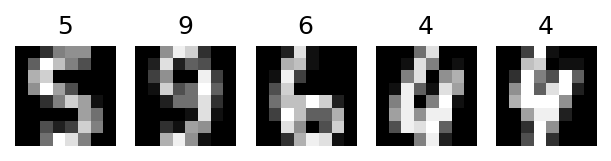

In [74]:
f, axes = plt.subplots(nrows=1, ncols=5, figsize=(5, 1), dpi=150)
for i, ax in enumerate(axes.flatten()):
    ax.set_title(np.argmax(Y_train[i]), fontsize=12)
    ax.imshow(X_train[i].reshape([8, 8]), cmap='gray')
    ax.axis('off')

plt.show()

In [69]:
t_sizes = [64, 20, 10]
t_params = init_mlp(sizes, key=key)
for w, b in t_params:
    print(w.shape, b.shape)
    print(np.max(w), np.min(w), np.max(b), np.min(b))

(512, 64) (512,)
0.013919415547037097 -0.013563200442957597 0.0 0.0
(512, 512) (512,)
0.009109267858624214 -0.008827835936286691 0.0 0.0
(10, 512) (10,)
0.013216896499792432 -0.012905724942719316 0.0 0.0


In [118]:
sizes = [64, 512, 512, 10]

# hyperparameters 
num_epochs = 20
batch_size = 100
learning_rate = 0.001
iteration = 0

params = init_mlp(sizes, key=key)

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)


training_loss_batch = []
training_loss_epoch = []
acc_train = []
acc_test  = []

params = get_params(opt_state)

for epoch in range(num_epochs):
    for X_batch, Y_batch in make_batches(X_train, Y_train, batch_size):
        # training step 
        Y_pred = batch_passforward_mlp(params, X_batch)
        params, opt_state, loss = update_mlp(params, X_batch, Y_batch, opt_state)
        #loss, params = update_mlp(params, X_batch, Y_batch, learning_rate)

        training_loss_batch += [loss]
    
    ave_training_loss = jnp.mean(jnp.array(training_loss_batch))
    training_loss_batch = []

    training_loss_epoch += [ave_training_loss]
    acc_train += [accuracy(params, X_train, Y_train)]
    acc_test  += [accuracy(params, X_test, Y_test)]

    print(f'iter: {iteration}, loss: {training_loss_epoch[-1]:.4f}, train acc: {acc_train[-1]:.2f}, test acc: {acc_test[-1]:.2f}')
    iteration += 1

       
        # update the parameters 
        

iter: 0, loss: 300.4130, train acc: 0.39, test acc: 0.39
iter: 1, loss: 180.2887, train acc: 0.73, test acc: 0.73
iter: 2, loss: 102.3795, train acc: 0.81, test acc: 0.80
iter: 3, loss: 72.9300, train acc: 0.88, test acc: 0.88
iter: 4, loss: 59.2734, train acc: 0.91, test acc: 0.90
iter: 5, loss: 48.3552, train acc: 0.92, test acc: 0.91
iter: 6, loss: 42.4296, train acc: 0.92, test acc: 0.91
iter: 7, loss: 40.1504, train acc: 0.94, test acc: 0.91
iter: 8, loss: 35.1466, train acc: 0.95, test acc: 0.92
iter: 9, loss: 33.3508, train acc: 0.94, test acc: 0.91
iter: 10, loss: 30.0370, train acc: 0.95, test acc: 0.94
iter: 11, loss: 28.0976, train acc: 0.95, test acc: 0.93
iter: 12, loss: 25.7107, train acc: 0.96, test acc: 0.94
iter: 13, loss: 23.2968, train acc: 0.97, test acc: 0.94
iter: 14, loss: 21.5535, train acc: 0.96, test acc: 0.93
iter: 15, loss: 22.2981, train acc: 0.96, test acc: 0.94
iter: 16, loss: 21.7804, train acc: 0.97, test acc: 0.94
iter: 17, loss: 18.5492, train acc: 0.

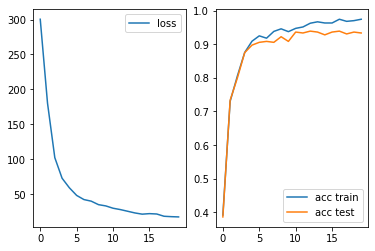

In [121]:
plt.subplot(1, 2, 1)
sns.lineplot(x=np.arange(num_epochs), y=np.array(training_loss_epoch), label='loss')

plt.subplot(1, 2, 2)
sns.lineplot(x=np.arange(num_epochs), y=np.array(acc_train), label='acc train')
sns.lineplot(x=np.arange(num_epochs), y=np.array(acc_test), label='acc test')

plt.show()